In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

# Function to remove seasonal mean and divide by seadonal standard deviation
def anomalize(dataseries, divide_by_std=True, reference_bounds = None, cycle_length=12, return_cycle=False):
    if reference_bounds is None:
        reference_bounds = (0, len(dataseries))

    anomaly = np.copy(dataseries)
    for t in range(cycle_length):
        if return_cycle:
            anomaly[t::cycle_length] = dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
        else:
            anomaly[t::cycle_length] -= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
            if divide_by_std:
                anomaly[t::cycle_length] /= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].std(axis=0)
    return anomaly


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp

from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

import os

import pkg_resources

In [2]:
def deTrend_deSeasonalize(data, show_plot = True):
    # step 1: seasonal component
    decomposition = seasonal_decompose(data, model='additive', period=12)
    data = data - decomposition.seasonal
    # step 2: Trend based on Gaussian kernel smoother
    smoothed = pp.smooth(np.copy(data), smooth_width=15 * 12, residuals=False)
    index = range(0, len(data))

    if show_plot == True:
        plt.plot(index, data)
        plt.plot(index,smoothed)
        plt.legend(['data', 'Smoothed trend'])
        plt.title("Deseasonalized data with smoothed trend")
        plt.show()

    else:
        result = data - smoothed
        return result

In [3]:
def deTrend(data):
    # Trend based on Gaussian kernel smoother
    smoothed = pp.smooth(np.copy(data), smooth_width=30 * 12, residuals=True)
    return smoothed


In [28]:
# Function that makes El nino, La nina mask
# input data from correct years + 1 from the climate explorer
# set to False if we do NOT want to mask this value

def mask_maker(df_sstnino34):
    nino34list = df_sstnino34[:,1:].reshape(-1)

    nino34list = deTrend(nino34list[:-8])
    nino34list = np.append(nino34list, np.zeros(8))
    nino34list_by_year = nino34list.reshape(-1,12)

    # NINO MASK
    
    ninamask = np.ones(len(nino34list)).reshape(-1,12)
    ninomask = np.ones(len(nino34list)).reshape(-1,12)
    neutralmask = np.ones(len(nino34list)).reshape(-1,12)

    for i in range(len(nino34list_by_year)-1):
        if (nino34list_by_year[i,10] + nino34list_by_year[i,11] + nino34list_by_year[i+1,0])/3 > 0.5:
            ninomask[i,1:] = False
            ninomask[i+1,0] = False
    ninomask = ninomask[:len(ninomask),:].reshape(-1)
    ninomask = ninomask[:-8]
    
    for i in range(len(nino34list_by_year)-1):
        if (nino34list_by_year[i,10] + nino34list_by_year[i,11] + nino34list_by_year[i+1,0])/3 < -0.5:
            ninamask[i,1:] = False
            ninamask[i+1,0] = False
    ninamask = ninamask[:len(ninamask),:].reshape(-1)
    ninamask = ninamask[:-8]
    
    for i in range(len(nino34list_by_year)-1):
        if -0.5 < (nino34list_by_year[i,10] + nino34list_by_year[i,11] + nino34list_by_year[i+1,0])/3 < 0.5:
            neutralmask[i,1:] = False
            neutralmask[i+1,0] = False
    #neutralmask = neutralmask[:len(neutralmask)-1,:].reshape(-1)
    neutralmask = neutralmask[:len(neutralmask),:].reshape(-1)  
    neutralmask = neutralmask[:-8]
    
    return ninomask, ninamask, neutralmask

In [29]:
os.chdir('/Users/hp/Documents/Econometrics; Climate Economics/Scriptie/Data') 

In [30]:
# Pick time range
start_year = 1950
length = 12*(2023 - start_year)

reanalysis_data = np.vstack((
    np.loadtxt('iera5_slp_130-150E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_t2m_-150--130E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_t2m_-100--80E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_u10m_-210--100E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_trbflx_-210--100E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
                )).T
T, N = reanalysis_data.shape

reanalysis_data = reanalysis_data[:-8]

In [31]:
# Simple way to define time axis
datatime = np.linspace(start_year, 2023-1./12., T)

# Variable names used throughout
var_names = ['WPAC', 'CPAC', 'EPAC', 'ZWS', 'NHF']

df_reanalysis = pd.DataFrame(reanalysis_data, columns=var_names)


In [32]:
dataframe_reanalysis = pp.DataFrame(np.copy(reanalysis_data), 
                         datatime = np.arange(len(reanalysis_data)), 
                         var_names=var_names)

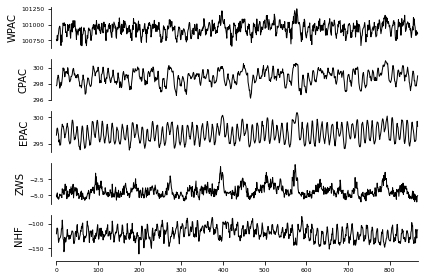

In [33]:
tp.plot_timeseries(dataframe_reanalysis); plt.show()

In [34]:
cpac_detrend = deTrend_deSeasonalize(df_reanalysis['CPAC'], show_plot = False)
epac_detrend = deTrend_deSeasonalize(df_reanalysis['EPAC'], show_plot = False)
wpac_detrend = deTrend_deSeasonalize(df_reanalysis['WPAC'], show_plot = False)
zws_detrend = deTrend_deSeasonalize(df_reanalysis['ZWS'], show_plot = False)
nhf_detrend = deTrend_deSeasonalize(df_reanalysis['NHF'], show_plot = False)

In [35]:
df_reanalysis_processed = pd.DataFrame({'WPAC': wpac_detrend, 
                                        'CPAC': cpac_detrend, 
                                        'EPAC': epac_detrend,
                                        'ZWS': zws_detrend,
                                        'NHF': nhf_detrend})

In [36]:
dataframe = pp.DataFrame(df_reanalysis_processed.values, datatime = {0:np.arange(len(df_reanalysis_processed))}, var_names= var_names)

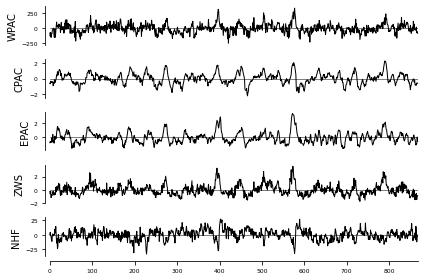

In [37]:
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
plt.show()

In [38]:
parcorr = ParCorr(significance='analytic', mask_type='x')

In [39]:
nino34reanalysis = np.loadtxt('iera5_t2m_-170--120E_-5-5N_n.dat.txt', skiprows=20)[:, :]

ninomask_reanalysis, ninamask_reanalysis, neutralmask_reanalysis = mask_maker(nino34reanalysis)


In [40]:
# Construct mask for spring barrier
cycle_length = 12
springbarrier_mask = np.ones(df_reanalysis_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    springbarrier_mask[i::cycle_length, :] = False

# Spring barrier PCMCI


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 5 link(s):
        (ZWS -2): max_pval = 0.00000, min_val =  0.226
        (CPAC -2): max_pval = 0.00052, min_val =  0.136
        (WPAC -1): max_pval = 0.00106, min_val =  0.129
        (WPAC -2): max_pval = 0.00621, min_val =  0.108
        (EPAC -1): max_pval = 0.03838, min_val =  0.082

    Variable CPAC has 4 link(s):
        (CPAC -1): max_pval = 0.00000, min_val =  0.717
        (ZWS -1): max_pval = 0.00000, min_val =  0.433
        (WPAC -3): max_pval = 0.00398, min_val = -0.113
        (CPAC -3): max_pval = 0.01631, min_val = -0.095

    Variable EPAC has 4 link(s):
        (EPAC -1): max_pval = 0.00000, min_val =  0.699
        (ZWS -1): max_pval = 0.00002, min_val =  0.170
        (ZWS -2): max_pval = 0.00010, min_val =  0.153
      

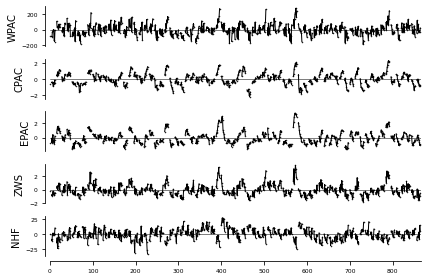

In [41]:
dataframe = pp.DataFrame(np.copy(df_reanalysis_processed), datatime = {0:np.arange(len(df_reanalysis_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_springbarrier = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

In [42]:
# contstruct spring barrier mask
cycle_length = 12
springbarrier_mask = np.ones(df_reanalysis_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    springbarrier_mask[i::cycle_length, :] = False
    
    
# Additionally mask to pick only La Nina phases in spring barrier
for t in range(springbarrier_mask.shape[0]):
    if ninamask_reanalysis[t] == True:
        springbarrier_mask[t] = True

# Nina PCMCI


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 3 link(s):
        (WPAC -2): max_pval = 0.00000, min_val =  0.272
        (EPAC -1): max_pval = 0.01016, min_val =  0.152
        (CPAC -2): max_pval = 0.02699, min_val =  0.131

    Variable CPAC has 3 link(s):
        (CPAC -1): max_pval = 0.00000, min_val =  0.666
        (ZWS -1): max_pval = 0.00000, min_val =  0.340
        (WPAC -3): max_pval = 0.04536, min_val =  0.118

    Variable EPAC has 3 link(s):
        (EPAC -1): max_pval = 0.00000, min_val =  0.659
        (ZWS -1): max_pval = 0.02507, min_val =  0.133
        (EPAC -3): max_pval = 0.02595, min_val = -0.132

    Variable ZWS has 2 link(s):
        (ZWS -1): max_pval = 0.00003, min_val =  0.243
        (ZWS -2): max_pval = 0.00004, min_val =  0.241

    Variable NHF has 3 link(

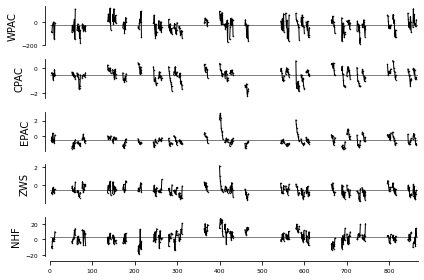

In [43]:
dataframe = pp.DataFrame(np.copy(df_reanalysis_processed), datatime = {0:np.arange(len(df_reanalysis_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_nina = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

In [44]:
# contstruct spring barrier mask
cycle_length = 12
springbarrier_mask = np.ones(df_reanalysis_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    springbarrier_mask[i::cycle_length, :] = False

# Additionally mask to pick only neutral and La Nina phases
for t in range(springbarrier_mask.shape[0]):
    if ninomask_reanalysis[t] == True:
        springbarrier_mask[t] = True

# Nino PCMCI


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 1 link(s):
        (ZWS -2): max_pval = 0.00000, min_val =  0.502

    Variable CPAC has 3 link(s):
        (CPAC -1): max_pval = 0.00000, min_val =  0.614
        (ZWS -1): max_pval = 0.00000, min_val =  0.477
        (CPAC -3): max_pval = 0.00058, min_val =  0.292

    Variable EPAC has 5 link(s):
        (EPAC -1): max_pval = 0.00000, min_val =  0.808
        (ZWS -2): max_pval = 0.01099, min_val =  0.219
        (ZWS -1): max_pval = 0.02375, min_val =  0.195
        (CPAC -2): max_pval = 0.02478, min_val = -0.195
        (EPAC -2): max_pval = 0.03571, min_val = -0.182

    Variable ZWS has 3 link(s):
        (ZWS -2): max_pval = 0.00000, min_val =  0.437
        (ZWS -1): max_pval = 0.00216, min_val =  0.264
        (WPAC -2): max_pval = 0

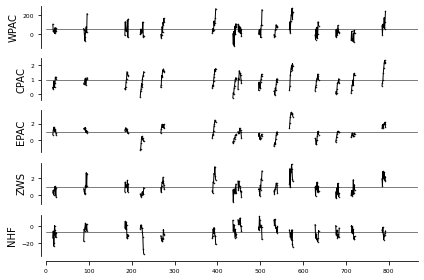

In [45]:
dataframe = pp.DataFrame(np.copy(df_reanalysis_processed), datatime = {0:np.arange(len(df_reanalysis_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_nino = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

# Plot DAGs spring barrier, nino years, nina years

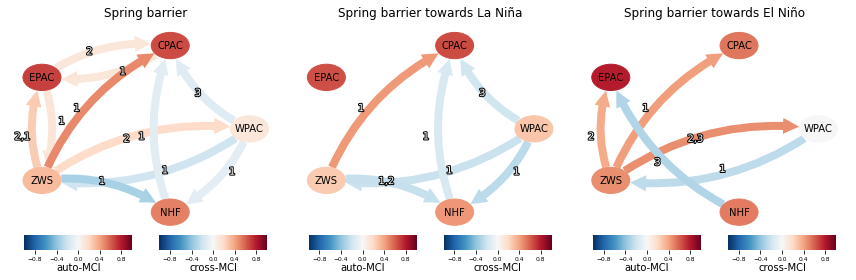

In [46]:
## PLOT ALL DAGS

fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

#tp.plot_graph(
#    val_matrix=results_nomask['val_matrix'],
#    graph=results_nomask['graph'],
#    var_names=var_names,
#    fig_ax= (fig, axes[0,0]))
#axes[0, 0].set_title('All observations')

tp.plot_graph(
    val_matrix=results_springbarrier['val_matrix'],
    graph=results_springbarrier['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    fig_ax= (fig, axes[0]))
axes[0].set_title('Spring barrier')

tp.plot_graph(
    val_matrix=results_nina['val_matrix'],
    graph=results_nina['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    fig_ax= (fig, axes[1]))
axes[1].set_title('Spring barrier towards La Niña')

tp.plot_graph(
    val_matrix=results_nino['val_matrix'],
    graph=results_nino['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    fig_ax= (fig, axes[2]))
axes[2].set_title('Spring barrier towards El Niño')

plt.subplots_adjust(hspace=0.8)
plt.show()